# Dataset Description and Setup

We are working with the **cats_vs_dogs** dataset, which consists of images of cats and dogs across 34 different breeds. Each example in this dataset is a 224x224x3 image, where the last dimension represents the 3 color channels in RGB encoding. The dataset is divided into three parts: training, validation (dev), and testing. The aim of this assignment is to **predict breeds of cats and dogs based on images** using pre-trained model, **EfficientNet**, which will be used to initialize our model and potentially improve the training.



## Data Details

- **Training and Validation Datasets**:
  - These datasets are stored in TFRecord files.
  - Each element is encoded as a `tf.train.Example`.
  - True labels are provided for these datasets and should be used for training the model and validation (including early stopping).

- **Test Dataset**:
  - This dataset is given as a pickled list.
  - It lacks labels and should only be used for making predictions and submission.

## Pre-trained Model

We are provided with weights of a pre-trained model.

# Imports

In [1]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

from DS_2_2024_HW2_efficient_net import EfficientNet

In [2]:
tf.keras.utils.set_random_seed(16)

## Data

In this section, we are processing the mentioned dataset of images of cats and dogs, each belonging to one of 34 breeds. We define constants for the image dimensions and number of breeds, and implement a function to parse and preprocess the data. The training and validation datasets are stored in TFRecord files, which we load and process using TensorFlow's `TFRecordDataset` class and a parsing function from practicals to decode the images and mask. The test dataset is provided as a pickled list, which we load using Python's `pickle` module and convert into a TensorFlow dataset. This preprocessing ensures the data is in the correct format for training and evaluating a machine learning model.


In [3]:
# Height, width and number of channels
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example

In [4]:
# Load data. Train & Dev datasets are stored as tfrecord objects (see https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)-
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord")
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord")
    
# Process data. Train & Dev are decoded from jpeg; Test data are constructed from list.
train = train.map(parse)
dev = dev.map(parse)

with open("hw2_outofsample.pickle", 'rb') as f:
    test = pickle.load(f)
test = tf.data.Dataset.from_tensor_slices(test) # see https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Data exploration

Next we would like to briefly epxlore the given dataset. There are 2142 + 306 entries, where each label has 63 pictures ( 9 resp. for dev). On the first glance we did not spot any anomalies or irrelevant entry. We provided visualitation of random breeds in the first chunk, in the second and third we also plotted a corresponding outline of explain the reason.

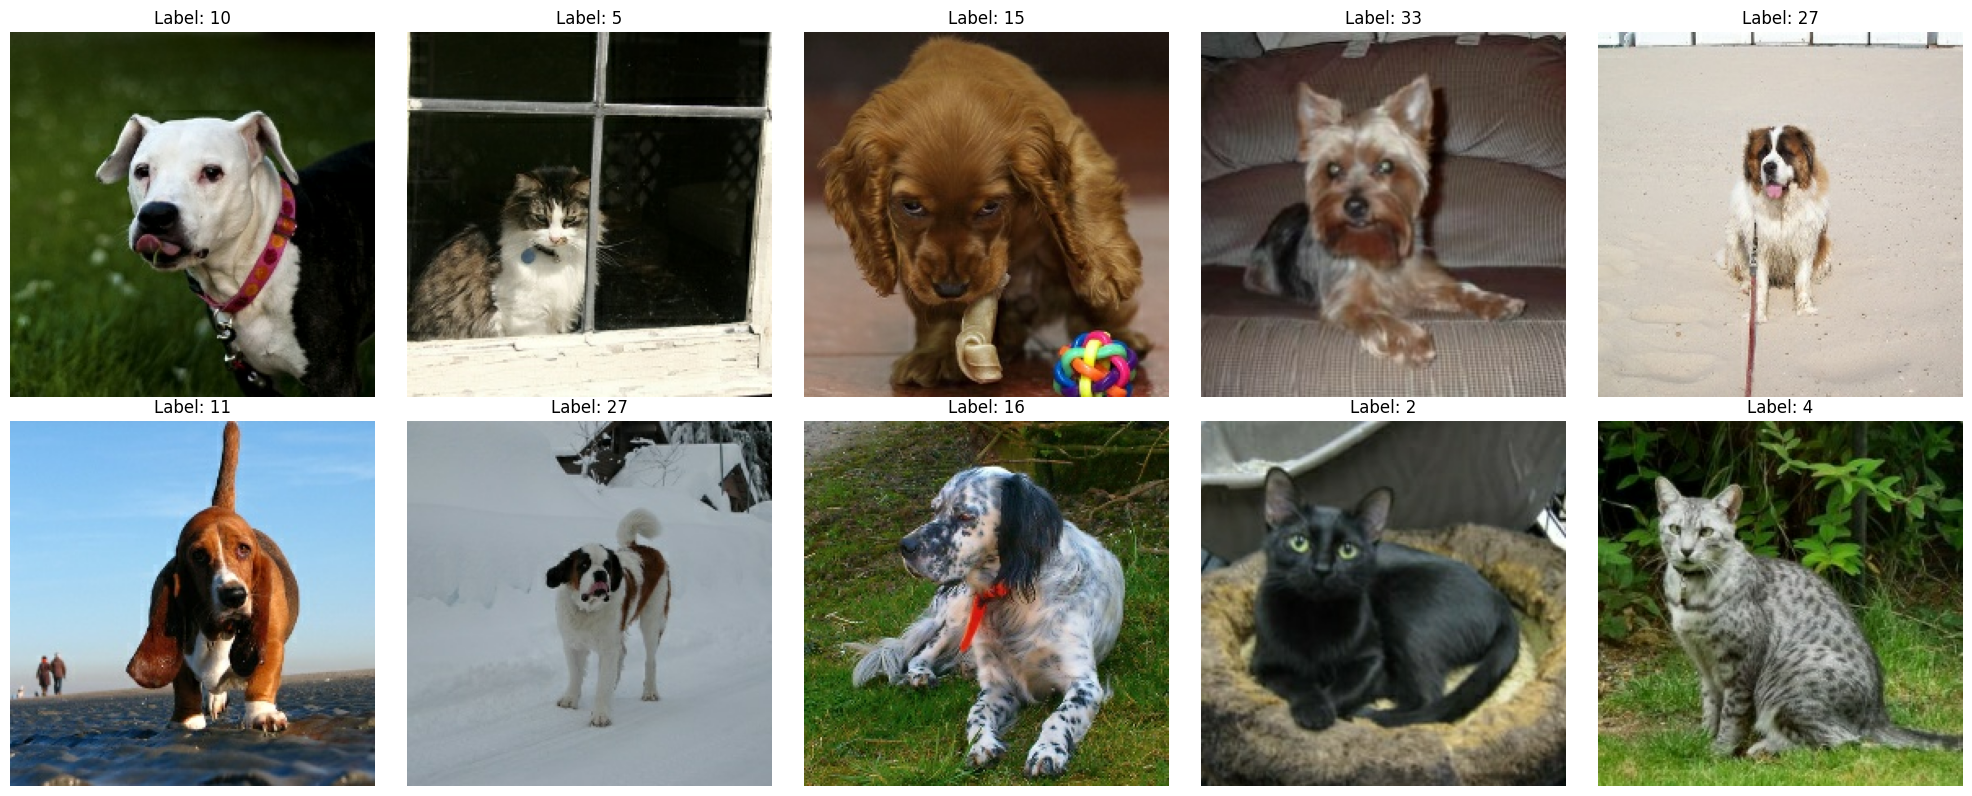

In [5]:
def display_images(dataset, num_images):
    columns = 5
    rows = (num_images + columns - 1) // columns  # Calculate required rows for given number of images
    plt.figure(figsize=(columns * 4, rows * 4))  # Adjust the figure size

    for idx, data in enumerate(dataset.take(num_images)):
        image, label = data['image'], data['label']
        plt.subplot(rows, columns, idx + 1)  # Specify subplot position
        plt.imshow(image.numpy())  # Display the image
        plt.title(f"Label: {label.numpy()}")  # Add title with label
        plt.axis('off')  # Hide axes for a cleaner look

    plt.tight_layout()  # Optimize layout
    plt.show()

# Display the first 10 images from the training dataset
display_images(dev, 10)

In [6]:
def no_augment(element):
    image = element['image']
    label = element['label']
    mask = element['mask']
    return image, label, mask

Total images in train with label 30: 63


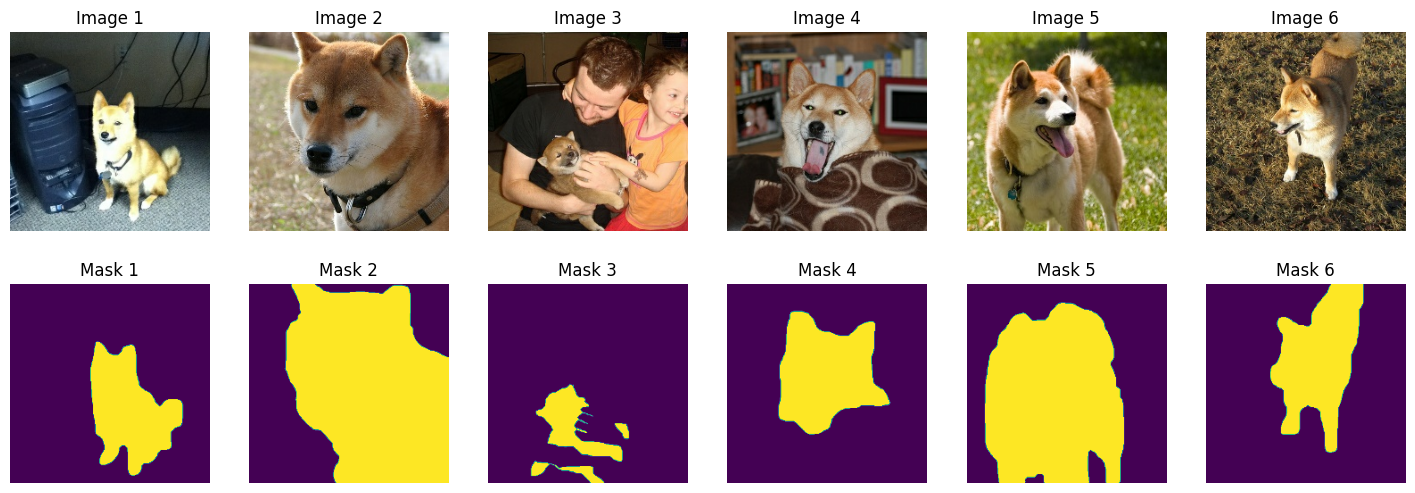

In [7]:
#If we want to check train for a specific breed
breed = 30
num_images = 6

train_plt = train.map(no_augment)

total_images = train_plt.filter(lambda image, label, mask: label == breed).reduce(0, lambda x, _: x + 1)
filtered_dataset = train_plt.filter(lambda image, label, mask: label == breed).take(num_images)

# Create subplots for each image
fig, axs = plt.subplots(2, num_images, figsize=(3*num_images, num_images))

for i, (image, label, mask) in enumerate(filtered_dataset):
    axs[0, i].imshow(image.numpy())
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Image {i+1}")

    axs[1, i].imshow(mask.numpy())
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Mask {i+1}")

print(f"Total images in train with label {breed}: {total_images}")

plt.show()

Total images in dev with label 30: 9


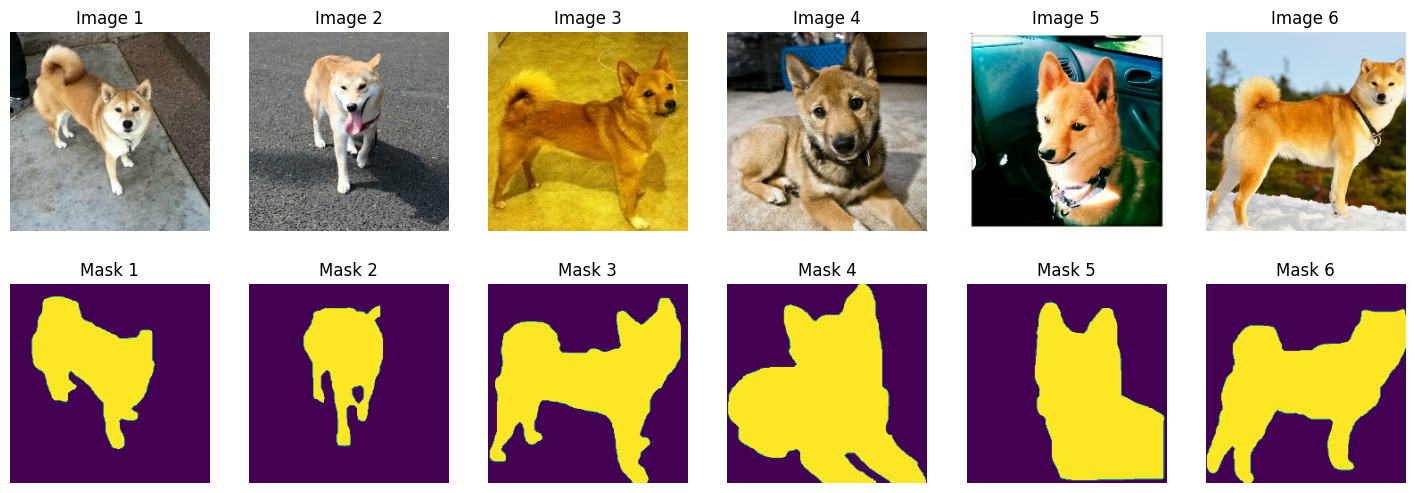

In [8]:
#If we want to check validation for a specific breed
breed = 30
num_images = 6

validation_plt = dev.map(no_augment)

total_images = validation_plt.filter(lambda image, label, mask: label == breed).reduce(0, lambda x, _: x + 1)
filtered_dataset = validation_plt.filter(lambda image, label, mask: label == breed).take(num_images)

# Create subplots for each image
fig, axs = plt.subplots(2, num_images, figsize=(3*num_images, num_images))

for i, (image, label, mask) in enumerate(filtered_dataset):
    axs[0, i].imshow(image.numpy())
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Image {i+1}")

    axs[1, i].imshow(mask.numpy())
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Mask {i+1}")

print(f"Total images in dev with label {breed}: {total_images}")

plt.show()

# Building Model
Firstly, we used an EfficientNet model because it's well-known for achieving high accuracy while being computationally efficient. We started by creating a base model with a appropriate image size of 224x224 pixels, and we used pre-trained weights 'efficientnet.h5' to leverage the knowledge already learned from large datasets. We excluded the top layer to customize the model for our specific task. Additionally, we applied a dropout rate of 0.2 to reduce the risk of overfitting, which means making the model perform well on new, unseen data. Finally, we used the base_model.summary() function to display the structure and details of our model, which helps us understand the different layers and the number of parameters involved.

In [9]:
# Parameters cheatsheet
######################################################################################################################################
# Call constructor of EfficientNet and call your object 'base_model'. You need to specify several parameters:
# - width_coefficient, depth_coefficient: determine the scale for depth and width of the network. Reasonable to start with both equal to 1.0
# - default_resolution: resolution of an input image
# - dropout_rate: dropout rate used throughout the network
# - include_top: if True then the network will include the final classification layer and produce a prediction for 1000 classes in ImageNet classification dataset,
# if False, the network will return 'image features' (the result of the last global average pooling)
# weights: path to the file for pre-trained weights. Use 'efficientnet.h5' that you have downloaded from the Kaggle competition
####################################################################################################################################x#

# Create the EfficientNet model
base_model = EfficientNet(
    default_resolution=(224),
    width_coefficient=1.0,
    depth_coefficient=1.0,
    include_top=False,
    weights='efficientnet.h5',
    dropout_rate=0.2
)

# Summary of the model architecture
base_model.summary()

Model: "efficientnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                      

Initially, our EfficientNet model had over 4 million trainable parameters, which is not ideal for our purposes due to the high computational cost and potential overfitting issues. To address this, we significantly reduced the number of trainable parameters to around 42,000. This makes the model more efficient and less likely to overfit, ensuring better performance on new data.

<font color='red'>We kept BatchNormalization layers trainable and froze everything else, which is not standard procedure, usually, we would keep the whole model frozen or make trainable only few last layers.</font>

In our effort to make the model more efficient, we restructured it by adding a custom classifier on top of the EfficientNet base. The code initializes an input layer with the shape [H, W, C], where H, W, and C represent the height, width, and number of channels of the input images. The output from the base model is passed through a dense layer with 32 units using the ReLU activation function, followed by another dense layer with 34 units using the softmax activation function for classification. <font color='red'>34 is the number of breeds, 32 is selected randomly.</font>

For complettness we provided mentioned activation functions, where $x_i$ is weighted input from previous layers:
\begin{align}
&\text{ReLU}(x_i) = \max(0, x_i),\\
&\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}.\\
\end{align}

We proceeded by visualizing the layers of our model, providing a comprehensive overview of its architecture, including the input and output shapes. This visualization aids in understanding how data flows through the network. Additionally, we compiled the model by specifying the optimizer, loss function, and evaluation metrics. We utilized the `Adam optimizer` for efficient parameter updates, `Sparse Categorical Crossentropy loss` for multi-class classification tasks, and `Sparse Categorical Accuracy` as the metric to monitor the model's performance during training and evaluation.

<font color='red'>If we wanted significant savings in terms of computaion, we could freeze all the layers of the original NN and use it to produce new input data, which we would then use to train our model. However this causes different issues with image augmentation as it needs to be done beforehand.</font>

<font color='red'>Also, if we want the base model all forzen, calling it as 'base_model(input,training=False)' should be considered. It causes forward pass to behave like in inference mode, which influences dropout and batchnormalization layers, which should lead to better results.</font>

In [10]:
# Calling constuctor of EfficientNet you have constructed a tf.keras.Model object. 
# Iterate over layers of that model and set their attribute 'trainable' to False for most of them,
# (in this way you will train only some of the large number of parameters; - is it reasonable to train the first or the last layers?)
# Use method .summary() to investigate the number of trainable and non-trainable parameters
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization): #BatchNormalization layers are typically kept trainable to allow them to adapt during fine-tuning. - !!!NOT GENERALLY TRUE!!!, however it works in this specific case
        layer.trainable = True
    else:
        layer.trainable = False

# We don't want to print out all the layers again, only number of (non-)trainable parameters
def custom_summary(model):
    total_params = model.count_params()
    trainable_params = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
    non_trainable_params = total_params - trainable_params

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

# Call the custom summary function
custom_summary(base_model)

Total parameters: 4049564
Trainable parameters: 42016
Non-trainable parameters: 4007548


<font color='red'>Data augmentation should have been implemented in this cell as shown using the comment (not tested it would work correctly btw, the augment function would have to be defined before this, see dog_augmentation usage in CNN_intro)</font>

In [11]:
# Use API logic seen on the practicals to build the following model:
# The input layer takes images with 3 channels and passes them to the initialized EfficientNet model
# After processing through Efficient model, add few more fully connected layers, with regularization of your choice
# Output of your model should be a vector of probabilities for each of the breed.

inputs = tf.keras.layers.Input([H, W, C])
#inputs = augment_train(inputs)
hidden = base_model(inputs)[0]
dense = tf.keras.layers.Dense(32, activation = tf.nn.relu)(hidden)
outputs = tf.keras.layers.Dense(34, activation = tf.nn.softmax)(dense)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet (Functional)   [(None, 1280),            4049564   
                              (None, 7, 7, 1280),                
                              (None, 14, 14, 112),               
                              (None, 28, 28, 40),                
                              (None, 56, 56, 24),                
                              (None, 112, 112, 16)]              
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 34)                1122      
                                                             

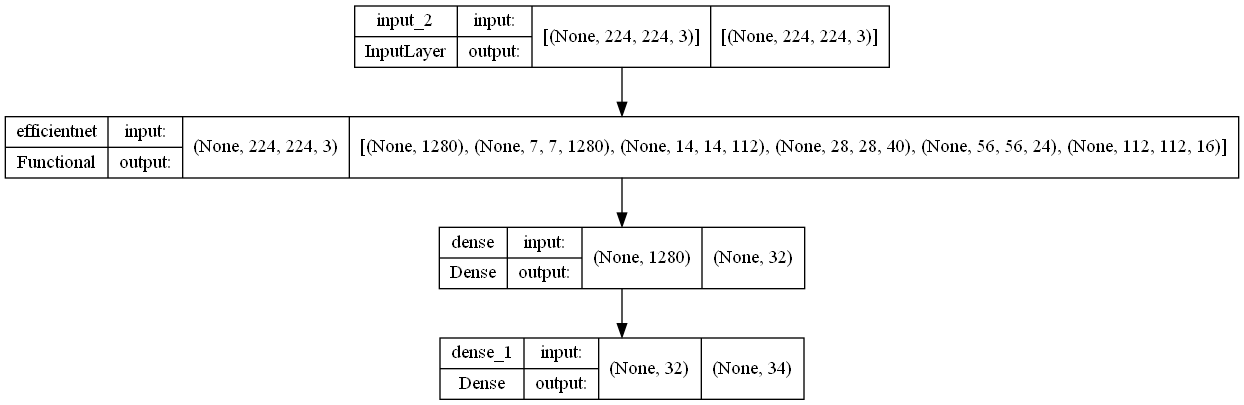

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

## Augmentation

Next  we establish a pipeline for data augmentation and batching to enhance model robustness and performanceTwo functions, augment_train and augment_dev, are defined to handle data augmentation for training and development (validation) datasets respectively. Within these functions, various augmentation techniques such as random adjustments in JPEG quality and flipping of images are applied to the input images, aimed at diversifying the dataset and making the model more resilient to variations in real-world data. Augmenting only the training dataset helps prevent overfitting, while keeping the development dataset unchanged ensures unbiased evaluation of the model's performance during training. We tried other augmentation processes such as `random_random_zoom`, `random_crop` or `random_saturation`, but none yielded better model performance. Additionally, we included batch processing streamlines data manipulation, optimizing computational efficiency during model training.

<font color='red'>In order to implement data augmentation correctly, the following cell should have been above the model building cell.</font>

In [14]:
# We define pipeline that will consist of augmentation and batching

def augment_train(input):
    image = input['image']
    label = input['label']
    # Augmentation procedures (modify to your wish)

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])

    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']
    # Augmentation procedures (add to your wish)

    #image = tf.image.random_jpeg_quality(image,80,100)
    #image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    
    # Note: if we add augmentation also to dev dataset, we can assume that
    # performance of test dataset will be better as test dataset is not augmented
    
    #only causes to stop the training slightly earlier, which produced worse model:
    
    return image, label


<font color='red'>It is not necessary to implement label smoothing in the following way as it is a parameter of tf.keras.losses.CategoricalCrossentropy, however the one-hot encoding for target would still be necessary. (But this works correctly as well.)</font>

In [ ]:
# Label smoothing (to use this we need to adjust model compilation and fit to Categorical instead of SparseCategorical, however produces model with slightly worse accuracy

#impelemented in tf.keras.losses.CategoricalCrossentropy:
def label_smooth_train(image, labels, alpha, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    labels *= (1 - alpha)
    labels += alpha / n_labels
    return image, labels

#still necessary:
def label_smooth_dev(image, labels, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    return image, labels

# Batching and fitting

We are fitting our final model without using most of the methods that prevent overfitting, such as label smoothing, validation data augmentation, or additional dropout beyond what is included in EfficientNet. While this might seem unusual, it yielded the best performance in our experiments. Our models generally performed as well as or better on the final test data compared to the validation data, even without augmentation. This indicates some overfitting, with the training set accuracy around 99%. However, we hypothesize that slightly overfitting models may still show improvement, and we could later reintroduce regularization methods. Despite attempts, we have not yet found such a model.






<font color='red'>I believe that data augmentation is implemented incorrectly here, as we just modify our data once and use this modified version in every epoch, it should have been implemented during model building, to modify the data differently every time. (see dog_augmentation in CNN_intro)</font>

In [15]:
# Now we apply augmentation using .map()
train = train.map(augment_train)
validation= dev.map(augment_dev)

#smooth_alpha = 0.05
#n_labels = 34
#train = train.map(lambda x, y: label_smooth_train(x, y, smooth_alpha, n_labels))
#validation = validation.map(lambda x, y: label_smooth_dev(x, y, n_labels))

batch_size = 32 
# Apply .batch() to 'train' and 'dev' with some choice of batch size
train = train.batch(batch_size)
validation = validation.batch(batch_size)

In this final stage, we integrate the augmented data into our training and validation sets using the .map() function, applying the defined augmentation procedures to each element and batching the data. We proceed to train our model with early stopping, halting training when performance on the validation set stops improving to prevent overfitting. After experimenting with different numbers of epochs, we settled on 8, as increasing the count did not yield notable performance improvements.


In [16]:
# Fit your model using early stopping

epochs = 20 #We tried several variants, the 

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/train')

model.fit(train,
          epochs=epochs,
          validation_data=validation,
          callbacks=[early_call])

Epoch 1/20
67/67 [==============================] - 146s 2s/step - loss: 3.2481 - sparse_categorical_accuracy: 0.1937 - val_loss: 2.3666 - val_sparse_categorical_accuracy: 0.5686
Epoch 2/20
67/67 [==============================] - 143s 2s/step - loss: 1.9779 - sparse_categorical_accuracy: 0.5770 - val_loss: 0.9206 - val_sparse_categorical_accuracy: 0.7941
Epoch 3/20
67/67 [==============================] - 141s 2s/step - loss: 0.9409 - sparse_categorical_accuracy: 0.7913 - val_loss: 0.5242 - val_sparse_categorical_accuracy: 0.8529
Epoch 4/20
67/67 [==============================] - 141s 2s/step - loss: 0.5831 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.3922 - val_sparse_categorical_accuracy: 0.8660
Epoch 5/20
67/67 [==============================] - 141s 2s/step - loss: 0.4158 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.3537 - val_sparse_categorical_accuracy: 0.8791
Epoch 6/20
67/67 [==============================] - 141s 2s/step - loss: 0.2992 - sparse_categorical_accu

# Evaluate

Finally, we convert the test data into a TensorFlow dataset and apply batching with a consistent batch size of 32. Leveraging a pre-trained model, we predict class probabilities for each batch in the test dataset. These probabilities are subsequently transformed into class labels by selecting the class with the highest probability for each example. Our final model, under team *Wiedźmini*, achieved a test accuracy of **0.92666**  on Kaggle. You can find our submission [here](https://www.kaggle.com/competitions/data-science-2-2024-hw2/leaderboard).



In [17]:
# Load test dataset stored as pickled list.
with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)

# Apply batching also to 'test'
#test = test.batch(batch_size)
batch_size = 32 
test = test.batch(batch_size)
# Predict
test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

# Store results
pd.DataFrame({'ID, TARGET': test_prediction}).to_csv('data/hw2_outofsample_prediction_es20.csv', index=True, header=True)